# Grid for prediction (East Utrecht)

In [1]:
import os
import json
import joblib
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
from datetime import datetime
import matplotlib.pyplot as plt

## Spatial prediction

In [96]:
current_dir = os.getcwd()
datasetdir = os.path.join(current_dir, '../../data/raw')

In [97]:
def aoi_finder():
    utrecht_polygon_path = os.path.join(datasetdir, "utrecht polygon.csv")
    df = pd.read_csv(utrecht_polygon_path, sep=';')

    geo_shape_str = df.loc[0, "Geo Shape"] #coordinates of the polygon
    geo_shape = json.loads(geo_shape_str)
    coords = geo_shape["coordinates"][0]  # outer ring of the polygon

    utrecht_polygon = Polygon(coords)

    x1, y1 = 5.066884, 52.170366
    x2, y2 = 5.237030, 51.978896 

    def is_above_line(x, y):
        """Returns True if point (x, y) is above the diagonal line"""
        if x1 == x2:
            return y > y1  # vertical line
        slope = (y2 - y1) / (x2 - x1)
        y_on_line = slope * (x - x1) + y1
        return (y > y_on_line) and (x > x1)

    filtered_coords = [
        (x, y) for x, y in utrecht_polygon.exterior.coords
        if is_above_line(x, y)]

    if filtered_coords[0] != filtered_coords[-1]:
        filtered_coords.append(filtered_coords[0])

    #new precise polygon
    aoi = Polygon(filtered_coords)

    utrecht_mask = gpd.GeoDataFrame(geometry=[aoi], crs="EPSG:4326")
    return utrecht_mask

In [98]:
def create_prediction_grid(aoi_gdf, resolution=0.005, date="2020-07-01"):
    """resolution in degrees (~0.005 ≈ 500m), date format 'YYYY-MM-DD'"""
    aoi_geom = aoi_gdf.geometry.iloc[0]
    minx, miny, maxx, maxy = aoi_geom.bounds

    x_coords = np.arange(minx, maxx, resolution)
    y_coords = np.arange(miny, maxy, resolution)

    points = []
    for x in x_coords:
        for y in y_coords:
            p = Point(x + resolution / 2, y + resolution / 2)
            if aoi_geom.contains(p):
                points.append(p)

    gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")
    
    dt = pd.to_datetime(date).replace(hour=10).tz_localize("UTC")
    gdf["date"] = dt
    gdf["Year"] = dt.year

    return gdf

In [99]:
def visualize_grid(aoi_gdf, grid_gdf):
    fig, ax = plt.subplots(figsize=(10, 10))
    aoi_gdf.boundary.plot(ax=ax, color="black", linewidth=1.5, label="AOI Boundary")
    grid_gdf.plot(ax=ax, color="blue", markersize=3, alpha=0.6, label="Grid Points")
    ax.set_title("Grid over AOI", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [137]:
aoi = aoi_finder()
grid = create_prediction_grid(aoi, resolution=0.005, date="2010-07-01")

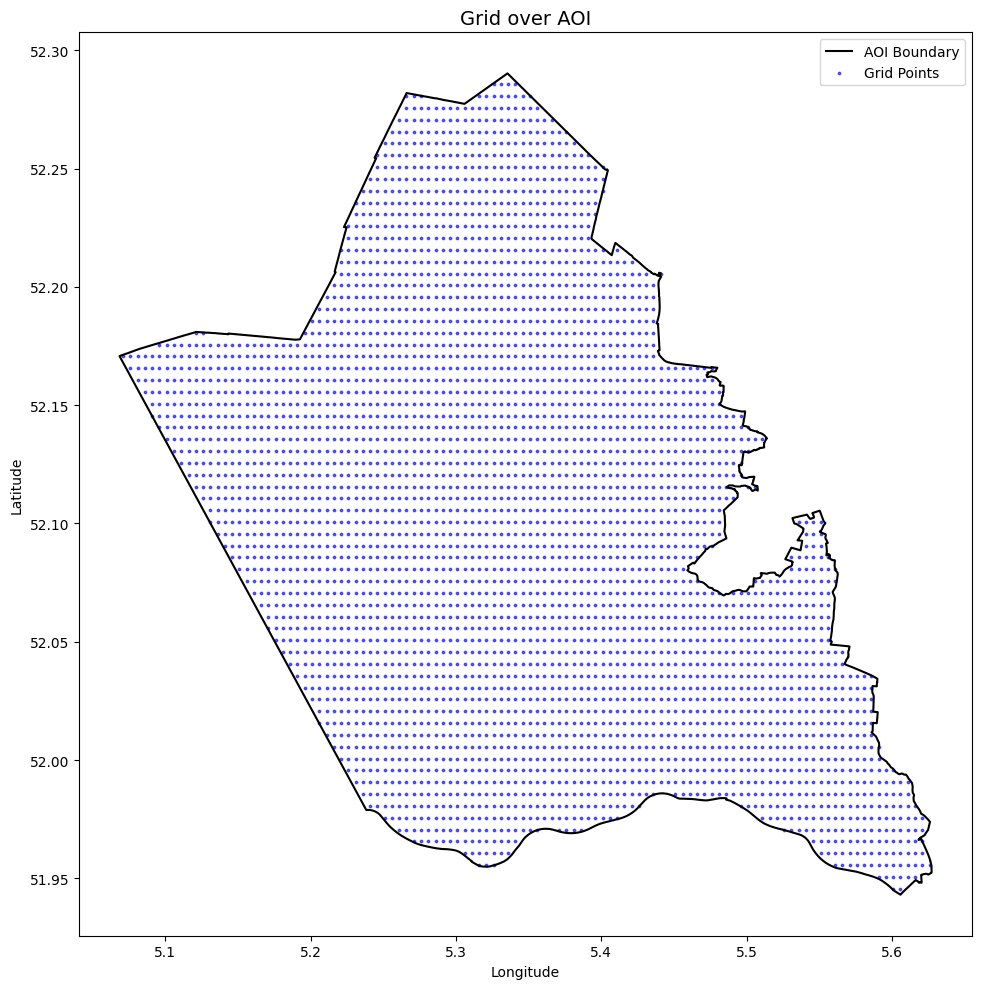

In [138]:
visualize_grid(aoi, grid)

In [ ]:
grid.to_csv("grid_2010.csv", index=False)

In [5]:
curr_dir = os.getcwd()
provinces_path = os.path.join(curr_dir, "../../data/raw/provinces_nl", "BestuurlijkeGebieden_2025.gpkg")

In [8]:
gdf = gpd.read_file(provinces_path, layer="provinciegebied")
gdf["naam"] = gdf["naam"].str.lower()

In [9]:
gdf

,identificatie,naam,code,ligt_in_land_code,ligt_in_land_naam,geometry
0,PV22,drenthe,22,6030,Nederland,"MULTIPOLYGON (((231437.815 516445.643, 231430...."
1,PV24,flevoland,24,6030,Nederland,"MULTIPOLYGON (((157694.139 473920.68, 159406.6..."
2,PV21,fryslân,21,6030,Nederland,"MULTIPOLYGON (((189491.268 535832.617, 189494...."
3,PV25,gelderland,25,6030,Nederland,"MULTIPOLYGON (((181361.527 418255.386, 181384...."
4,PV20,groningen,20,6030,Nederland,"MULTIPOLYGON (((265275.541 549247.459, 265285...."
5,PV31,limburg,31,6030,Nederland,"MULTIPOLYGON (((199549.696 308385.049, 199558...."
6,PV30,noord-brabant,30,6030,Nederland,"MULTIPOLYGON (((167812.721 359167.748, 167886...."
7,PV27,noord-holland,27,6030,Nederland,"MULTIPOLYGON (((131700.944 464257.265, 131702...."
8,PV23,overijssel,23,6030,Nederland,"MULTIPOLYGON (((248291.9 459808.449, 248302.77..."
9,PV26,utrecht,26,6030,Nederland,"MULTIPOLYGON (((131894.47 429932.357, 131917.5..."
